In [1]:
pip install --upgrade pyod


[notice] A new release of pip available: 22.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install combo


[notice] A new release of pip available: 22.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from pandas import json_normalize
import json
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import ruptures as rpt
from collections import Counter

In [4]:
columns = ['sensors.battery.temp',
       'sensors.battery.percent', 'sensors.battery.solarmv',
       'sensors.battery.current', 'sensors.battery.voltage',
       'sensors.battery.solarma', 'sensors.battery.charging',
        'solar_power', 'battery_power','power_difference']

In [5]:
# Reading back and setting the MultiIndex
labelled_data = pd.read_feather('MTDataBatch1\Labelled Data\Labelled Batch 1 - Updated.feather')
labelled_data.set_index(['DeviceId', 'time'], inplace=True)
# labelled_data

In [6]:
labelled_data

Id  \
DeviceId        time                                   
015262001277846 2021-04-21 03:18:26+10:00      10046   
                2021-04-21 03:17:52+10:00      10049   
                2021-04-21 03:27:29+10:00      15189   
                2021-04-21 03:28:29+10:00      15190   
                2021-04-21 03:21:30+10:00      15191   
...                                              ...   
015262001276442 2021-11-22 13:01:23+11:00  195389569   
                2021-11-22 13:04:17+11:00  195391320   
                2021-11-23 13:05:02+11:00  196545125   
                2021-11-24 13:05:36+11:00  197957676   
                2021-11-24 13:05:02+11:00  197957683   

                                                                    CreatedAt  \
DeviceId        time                                                            
015262001277846 2021-04-21 03:18:26+10:00  2021-04-20 17:18:57.3601057 +00:00   
                2021-04-21 03:17:52+10:00  2021-04-20 17:18:57.9206698 +00:00   
                2021-04-21 03:27:29+10:00  2021-04-20 17:30:00.0973275 +00:00   
                2021-04-21 03:28:29+10:00  2021-04-20 17:30:00.5204188 +00:00   
                2021-04-21 03:21:30+10:00  2021-04-20 17:30:00.6604193 +00:00   
...                                                                       ...   
015262001276442 2021-11-22 13:01:23+11:00  2021-11-22 02:02:07.3194074 +00:00   
                2021-11-22 13:04:17+11:00  2021-11-22 02:04:57.8307232 +00:00   
                2021-11-23 13:05:02+11:00  2021-11-23 02:05:44.6179891 +00:00   
                2021-11-24 13:05:36+11:00  2021-11-24 02:06:18.7314233 +00:00   
                2021-11-24 13:05:02+11:00  2021-11-24 02:06:19.3460223 +00:00   

                                                                    UpdatedAt  \
DeviceId        time                                                            
015262001277846 2021-04-21 03:18:26+10:00  2021-04-20 17:18:57.4751133 +00:00   
                2021-04-21 03:17:52+10:00  2021-04-20 17:18:58.0006530 +00:00   
                2021-04-21 03:27:29+10:00  2021-04-20 17:30:00.1973672 +00:00   
                2021-04-21 03:28:29+10:00  2021-04-20 17:30:00.6554035 +00:00   
                2021-04-21 03:21:30+10:00  2021-04-20 17:30:00.7254268 +00:00   
...                                                                       ...   
015262001276442 2021-11-22 13:01:23+11:00  2021-11-22 02:02:07.4609948 +00:00   
                2021-11-22 13:04:17+11:00  2021-11-22 02:04:57.9257593 +00:00   
                2021-11-23 13:05:02+11:00  2021-11-23 02:05:44.7707739 +00:00   
                2021-11-24 13:05:36+11:00  2021-11-24 02:06:18.8826478 +00:00   
                2021-11-24 13:05:02+11:00  2021-11-24 02:06:19.4060168 +00:00   

                                          State             timeStamp  \
DeviceId        time                                                    
015262001277846 2021-04-21 03:18:26+10:00     1  2021-04-20T17:18:26Z   
                2021-04-21 03:17:52+10:00     1  2021-04-20T17:17:52Z   
                2021-04-21 03:27:29+10:00     1  2021-04-20T17:27:29Z   
                2021-04-21 03:28:29+10:00     1  2021-04-20T17:28:29Z   
                2021-04-21 03:21:30+10:00     1  2021-04-20T17:21:30Z   
...                                         ...                   ...   
015262001276442 2021-11-22 13:01:23+11:00     1  2021-11-22T02:01:23Z   
                2021-11-22 13:04:17+11:00     1  2021-11-22T02:04:17Z   
                2021-11-23 13:05:02+11:00     1  2021-11-23T02:05:02Z   
                2021-11-24 13:05:36+11:00     1  2021-11-24T02:05:36Z   
                2021-11-24 13:05:02+11:00     1  2021-11-24T02:05:02Z   

                                             event  sensors.battery.extpower  \
DeviceId        time                                                           
015262001277846 2021-04-21 03:18:26+10:00   moving                     False   
                2021-04

In [7]:
labelled_data = labelled_data.sort_index(level=['DeviceId', 'time'])

In [8]:
numberOfDevices = len(labelled_data.groupby(level=0))
numberOfDevices

35

In [54]:
column_list = list(labelled_data.columns)
# for column in column_list:
#     print(column)
#     print(labelled_data[column].isnull().values.any())
#     print("-------------------")

In [55]:
len(labelled_data.columns)

31

In [56]:
train_size = int(len(labelled_data) * 0.80)
test_size = len(labelled_data) - train_size

In [57]:
# Training data : take all rows, and only device feature columns (From "sensors.battery.extpower" to "power_difference")
train_data = labelled_data.iloc[0:train_size,6:29]
test_data = labelled_data.iloc[train_size:len(labelled_data),6:29]
# Drop columns that have string values, or even NaN values 
# Manual Inspection proved them as non important for malfunction detectio.
train_data = train_data.drop('location.source', axis=1)
train_data = train_data.drop('location.numSats', axis=1)
train_data = train_data.drop('sensors.accelerometer.y', axis=1)
train_data = train_data.drop('sensors.accelerometer.x', axis=1)
train_data = train_data.drop('sensors.accelerometer.z', axis=1)
test_data = test_data.drop('location.source', axis=1)
test_data = test_data.drop('location.numSats', axis=1)
test_data = test_data.drop('sensors.accelerometer.y', axis=1)
test_data = test_data.drop('sensors.accelerometer.x', axis=1)
test_data = test_data.drop('sensors.accelerometer.z', axis=1)
# Labels is the array of values in "isDeviceWorking" -  convert to array of inetgers (0 or 1 values)
labels = labelled_data.iloc[:,29].values


In [58]:
# train_data_label = pd.DataFrame(labelled_data.iloc[0:train_size,29].values.astype(int), columns=['isDeviceWorking'])
# test_data_label = pd.DataFrame(labelled_data.iloc[train_size:len(labelled_data),29].values.astype(int), columns=['isDeviceWorking'])

In [59]:
len(train_data.columns)

18

In [60]:
# # Timestamps of devices that are working
# train_data_label.loc[train_data_label['isDeviceWorking'] == 1]

In [61]:
deviceWorkingLabels = labelled_data[['isDeviceWorking']].copy()
deviceWorkingLabels['isDeviceWorking'] = deviceWorkingLabels['isDeviceWorking'].astype(int)
deviceWorkingLabels

isDeviceWorking
DeviceId        time                                      
015262001090339 2021-06-11 12:27:45+10:00                1
                2021-06-11 12:34:17+10:00                1
                2021-06-11 16:34:25+10:00                1
                2021-06-11 20:34:39+10:00                1
                2021-06-12 00:35:02+10:00                1
...                                                    ...
015262001281806 2021-11-09 09:42:02+11:00                0
                2021-11-10 09:42:09+11:00                0
                2021-11-10 09:45:07+11:00                0
                2021-11-11 09:45:49+11:00                0
                2021-11-11 09:46:42+11:00                0

[1684083 rows x 1 columns]

In [62]:
train_data_label = deviceWorkingLabels.iloc[0:train_size,:]
test_data_label = deviceWorkingLabels.iloc[train_size:len(deviceWorkingLabels),:]

In [63]:
train_data_label

isDeviceWorking
DeviceId        time                                      
015262001090339 2021-06-11 12:27:45+10:00                1
                2021-06-11 12:34:17+10:00                1
                2021-06-11 16:34:25+10:00                1
                2021-06-11 20:34:39+10:00                1
                2021-06-12 00:35:02+10:00                1
...                                                    ...
015262001278133 2021-06-15 01:05:16+10:00                1
                2021-06-15 01:06:16+10:00                1
                2021-06-15 01:07:20+10:00                1
                2021-06-15 01:08:37+10:00                1
                2021-06-15 01:09:39+10:00                1

[1347266 rows x 1 columns]

In [64]:
# Scale column values (without normalizing the indexes)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

# Group by level 0, which is the first index corresponding to 'DeviceId'
# After applying the scaling function (which output a Numpy array), convert it to a dataframe

normalized_train_data = train_data.groupby(level=0).apply(lambda x : pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index).round(5))
    
normalized_test_data = test_data.groupby(level=0).apply(lambda x : pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index).round(5))

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(train_data)

# normalized_train_data = pd.DataFrame(scaler.transform(train_data))
# normalized_test_data = pd.DataFrame(scaler.transform(test_data))
normalized_test_data

sensors.battery.extpower  \
DeviceId        time                                                  
015262001278133 2021-06-15 01:10:39+10:00                      -1.0   
                2021-06-15 01:11:37+10:00                      -1.0   
                2021-06-15 01:12:40+10:00                      -1.0   
                2021-06-15 01:13:40+10:00                      -1.0   
                2021-06-15 01:14:42+10:00                      -1.0   
...                                                             ...   
015262001281806 2021-11-09 09:42:02+11:00                      -1.0   
                2021-11-10 09:42:09+11:00                      -1.0   
                2021-11-10 09:45:07+11:00                      -1.0   
                2021-11-11 09:45:49+11:00                      -1.0   
                2021-11-11 09:46:42+11:00                      -1.0   

                                           sensors.battery.temp  \
DeviceId        time                                              
015262001278133 2021-06-15 01:10:39+10:00              -0.46263   
                2021-06-15 01:11:37+10:00              -0.46263   
                2021-06-15 01:12:40+10:00              -0.46667   
                2021-06-15 01:13:40+10:00              -0.46667   
                2021-06-15 01:14:42+10:00              -0.46667   
...                                                         ...   
015262001281806 2021-11-09 09:42:02+11:00              -0.16606   
                2021-11-10 09:42:09+11:00              -0.16968   
                2021-11-10 09:45:07+11:00              -0.14079   
                2021-11-11 09:45:49+11:00              -0.04693   
                2021-11-11 09:46:42+11:00              -0.04693   

                                           sensors.battery.percent  \
DeviceId        time                                                 
015262001278133 2021-06-15 01:10:39+10:00                  1.00000   
                2021-06-15 01:11:37+10:00                  1.00000   
                2021-06-15 01:12:40+10:00                  1.00000   
                2021-06-15 01:13:40+10:00                  1.00000   
                2021-06-15 01:14:42+10:00                  1.00000   
...                                                            ...   
015262001281806 2021-11-09 09:42:02+11:00                 -0.97534   
                2021-11-10 09:42:09+11:00                 -0.98356   
                2021-11-10 09:45:07+11:00                 -0.99178   
                2021-11-11 09:45:49+11:00                 -1.00000   
                2021-11-11 09:46:42+11:00                 -0.99726   

                                           sensors.battery.solarmv  \
DeviceId        time                                                 
015262001278133 2021-06-15 01:10:39+10:00                 -1.00000   
                2021-06-15 01:11:37+10:00                 -0.97759   
                2021-06-15 01:12:40+10:00                 -1.00000   
                2021-06-15 01:13:40+10:00                 -1.00000   
                2021-06-15 01:14:42+10:00                 -1.00000   
...                                                            ...   
015262001281806 2021-11-09 09:42:02+11:00                 -0.38856   
                2021-11-10 09:42:09+11:00                 -0.22449   
                2021-11-10 09:45:07+11:00                 -0.24610   
                2021-11-11 09:45:49+11:00                 -0.13886   
                2021-11-11 09:46:42+11:00                 -0.13806   

                                           sensors.battery.current  \
DeviceId        time                                                 
015262001278133 2021-06-15 01:10:39+10:00                 -0.32571   
                2021-06-15 01:11:37+10:00                 -0.22286   
                2021-06-15 01:12:40+10:00                 -0.35429   
                2021-06-15 01:13:40+10:00                 -0.31429   
     

In [65]:
testdeviceIDs = set(normalized_test_data.index.get_level_values(0).tolist())
print(testdeviceIDs)

{'015262001278323', '015262001278315', '015262001278422', '015262001281806', '015262001278133', '015262001278513', '015262001278372'}


In [66]:
normalized_train_data[normalized_train_data.index.get_level_values('DeviceId') == '015262001277846']

sensors.battery.extpower  \
DeviceId        time                                                  
015262001277846 2021-04-21 03:17:52+10:00                      -1.0   
                2021-04-21 03:18:26+10:00                      -1.0   
                2021-04-21 03:19:31+10:00                      -1.0   
                2021-04-21 03:20:31+10:00                      -1.0   
                2021-04-21 03:21:30+10:00                      -1.0   
...                                                             ...   
                2021-05-30 07:30:27+10:00                      -1.0   
                2021-05-31 07:31:02+10:00                      -1.0   
                2021-05-31 07:31:46+10:00                      -1.0   
                2021-06-01 07:32:25+10:00                      -1.0   
                2021-06-02 07:32:31+10:00                      -1.0   

                                           sensors.battery.temp  \
DeviceId        time                                              
015262001277846 2021-04-21 03:17:52+10:00              -0.51194   
                2021-04-21 03:18:26+10:00              -0.51724   
                2021-04-21 03:19:31+10:00              -0.50663   
                2021-04-21 03:20:31+10:00              -0.50133   
                2021-04-21 03:21:30+10:00              -0.50663   
...                                                         ...   
                2021-05-30 07:30:27+10:00              -0.76658   
                2021-05-31 07:31:02+10:00              -0.80371   
                2021-05-31 07:31:46+10:00              -0.79841   
                2021-06-01 07:32:25+10:00              -0.97878   
                2021-06-02 07:32:31+10:00              -0.84085   

                                           sensors.battery.percent  \
DeviceId        time                                                 
015262001277846 2021-04-21 03:17:52+10:00                  0.98276   
                2021-04-21 03:18:26+10:00                  0.98707   
                2021-04-21 03:19:31+10:00                  0.99569   
                2021-04-21 03:20:31+10:00                  0.99569   
                2021-04-21 03:21:30+10:00                  0.98707   
...                                                            ...   
                2021-05-30 07:30:27+10:00                 -0.95690   
                2021-05-31 07:31:02+10:00                 -0.97414   
                2021-05-31 07:31:46+10:00                 -0.96983   
                2021-06-01 07:32:25+10:00                 -0.97414   
                2021-06-02 07:32:31+10:00                 -1.00000   

                                           sensors.battery.solarmv  \
DeviceId        time                                                 
015262001277846 2021-04-21 03:17:52+10:00                 -1.00000   
                2021-04-21 03:18:26+10:00                 -1.00000   
                2021-04-21 03:19:31+10:00                 -1.00000   
                2021-04-21 03:20:31+10:00                 -1.00000   
                2021-04-21 03:21:30+10:00                 -1.00000   
...                                                            ...   
                2021-05-30 07:30:27+10:00                 -0.69428   
                2021-05-31 07:31:02+10:00                 -0.58944   
                2021-05-31 07:31:46+10:00                 -0.58944   
                2021-06-01 07:32:25+10:00                 -0.78231   
                2021-06-02 07:32:31+10:00                 -0.75830   

                                           sensors.battery.current  \
DeviceId        time                                                 
015262001277846 2021-04-21 03:17:52+10:00                 -0.10811   
                2021-04-21 03:18:26+10:00                 -0.13514   
                2021-04-21 03:19:31+10:00                 -0.37838   
                2021-04-21 03:20:31+10:00                 -0.08108   
     

In [67]:
# LSTM is a type of RNN - we need sequences that act as an input to the LSTM. Chunks of timestamps are used as sequences

# Create sequences for each device. Take timestamps for each deviceId and form sequences taking 10 time steps at a time.
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [],[]
#     Get list of devieIDs in datatset
    deviceIDs = set(X.index.get_level_values(0).tolist())
    
    for device in deviceIDs:
        xForDeviceId = X[X.index.get_level_values('DeviceId') == device]
        yForDeviceId = y[y.index.get_level_values('DeviceId') == device]
        for i in range(len(xForDeviceId) - time_steps):
    #         Take the value of current time step (x) and do a bit of indexing. 
            v = xForDeviceId.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(yForDeviceId.iloc[i + time_steps].values)
            
    return np.array(Xs), np.array(ys)

# def create_dataset(X, y, time_steps = 1):
#     Xs, ys = [],[]
#     for i in range(len(X) - time_steps):
# #         Take the value of current time step (x) and do a bit of indexing. 
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)
#         ys.append(y.iloc[i + time_steps])
#     return np.array(Xs), np.array(ys)

In [68]:

# Create sequences for each device. Take timestamps for each deviceId and form sequences taking 10 time steps at a time.
def create_dataset_new(X, y, time_steps = 1):
    Xs, ys = [],[]
    index_of_sequences = []
#     Get list of devieIDs in datatset
    deviceIDs = set(X.index.get_level_values(0).tolist())
    
    for device in deviceIDs:
        xForDeviceId = X[X.index.get_level_values('DeviceId') == device]
        yForDeviceId = y[y.index.get_level_values('DeviceId') == device]
        for i in range(len(xForDeviceId) - time_steps):
    #         Take the value of current time step (x) and do a bit of indexing. 
            v = xForDeviceId.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(yForDeviceId.iloc[i + time_steps])
            index_of_sequences.append(yForDeviceId.iloc[i:i+1].index.tolist()[0])
#             print(index_of_sequences)
            
    return np.array(Xs), np.array(ys), index_of_sequences

In [69]:
# Convert train dataset into sequences
# Start with 10 time steps as history.

TIME_STEPS = 5

X_train_new, y_train_new, train_index_list= create_dataset_new(normalized_train_data, train_data_label.isDeviceWorking, TIME_STEPS)
len(train_index_list)

1347121

In [70]:
X_test_new, y_test_new, test_index_list = create_dataset_new(normalized_test_data,test_data_label.isDeviceWorking,TIME_STEPS)

In [71]:
test_data_label.isDeviceWorking.iloc[0:1].index.tolist()[0]

('015262001278133',
 Timestamp('2021-06-15 01:10:39+1000', tz='Australia/Sydney'))

In [72]:
test_index_list

[('015262001278323',
  Timestamp('2021-04-21 05:37:07+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-21 09:37:12+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-21 13:37:13+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-21 17:37:22+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-21 21:37:12+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-22 01:37:18+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-22 05:37:16+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-22 09:37:18+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-22 13:37:09+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-22 17:37:10+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-22 21:37:09+1000', tz='Australia/Sydney')),
 ('015262001278323',
  Timestamp('2021-04-23 01:37:16+

In [73]:
# Convert train dataset into sequences
# Start with 5 time steps as history.

# TIME_STEPS = 5

X_train, y_train = create_dataset(normalized_train_data, train_data_label, TIME_STEPS)
X_test, y_test = create_dataset(normalized_test_data,test_data_label,TIME_STEPS)

In [74]:
len(y_test)

336782

In [75]:
# The shape of the created sequence dataset: 
# it's a 3-D tensor which contains the timeseries, time step (history), and number of features
X_train.shape

(1347121, 5, 18)

In [76]:
y_train.shape

(1347121, 1)

In [77]:
# The sequences form the input to LSTM Autoencoder
# Idea behind this is to train a model based on our data, measure the error post training. 
# If the error is above a threshold, the model cannot reconstruct the data, indicative of an anomaly (predictive)

In [78]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

In [79]:
model = Sequential()
# Add an LSTM Layer with 64 units
model.add(LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))

# Add a dropout layer for regularization
model.add(Dropout(rate = 0.2))

# add a repeat layer
# This is important because we need to return the sequence for the next LSTM layer to work with.
model.add(RepeatVector(n=X_train.shape[1]))

# Add another LSTM Layer
model.add(LSTM(
    units=64, 
    return_sequences=True
))
model.add(Dropout(rate = 0.2))

# Output time distributed, fully connected layer 
# return same amount of data that was given as input, 
# that is reconstructed after learning the most important features of our data

model.add(TimeDistributed(Dense(
#     Number of features that we have is the number of dimensions of our predictions column, which is y_train.shape[1]
#     units = X_train.shape[2]   
    units = y_train.shape[1]
)))

model.compile(loss='mae', optimizer = 'adam')
model.summary()

In [80]:
# Train the model
# Important: In time series data, do not shuffle the data because data is history dependent
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle = False
)

Epoch 1/10
37888/37888 [==============================] - 478s 13ms/step - loss: 0.0476 - val_loss: 0.3166
Epoch 2/10
37888/37888 [==============================] - 461s 12ms/step - loss: 0.0479 - val_loss: 0.2791
Epoch 3/10
37888/37888 [==============================] - 461s 12ms/step - loss: 0.0541 - val_loss: 0.3125
Epoch 4/10
37888/37888 [==============================] - 460s 12ms/step - loss: 0.0555 - val_loss: 0.2891
Epoch 5/10
37888/37888 [==============================] - 468s 12ms/step - loss: 0.0817 - val_loss: 0.2052
Epoch 6/10
37888/37888 [==============================] - 465s 12ms/step - loss: 0.0986 - val_loss: 0.1807
Epoch 7/10
37888/37888 [==============================] - 463s 12ms/step - loss: 0.1106 - val_loss: 0.1666
Epoch 8/10
37888/37888 [==============================] - 463s 12ms/step - loss: 0.1036 - val_loss: 0.1626
Epoch 9/10
37888/37888 [==============================] - 462s 12ms/step - loss: 0.1064 - val_loss: 0.1665
Epoch 10/10
37888/37888 [============

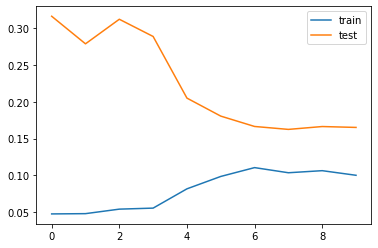

In [81]:
# As you can see, validation loss decreases steadily in above output (indicates some hints of possible learning)

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend();

In [82]:
# Take the predictions for the training data that we have
X_train_pred = model.predict(X_train)

42098/42098 [==============================] - 184s 4ms/step


In [83]:
X_train_pred.shape

(1347121, 5, 1)

In [84]:
X_train_pred_reshaped = X_train_pred[:,0,:]

In [85]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

C:\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

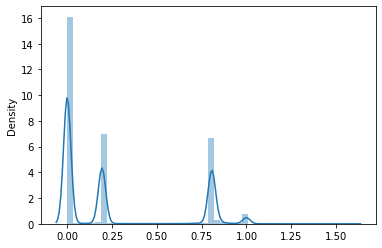

In [86]:
# take mae on training set and calculate error

import seaborn as sns
train_mae_loss = np.mean(np.abs(X_train_pred_reshaped - y_train.astype('float32')), axis =1)
sns.distplot(train_mae_loss, bins=50,kde=True)
# This gives us an idea of what to set as a threshold (which is a hyperparameter)

In [87]:
# Do the same for test set
X_test_pred = model.predict(X_test)
X_test_pred_reshaped = X_test_pred[:,0,:]
test_mae_loss = np.mean(np.abs(X_test_pred_reshaped - y_test.astype('float32')), axis =1)

10525/10525 [==============================] - 47s 5ms/step


In [88]:
X_test_pred_reshaped.shape

(336782, 1)

C:\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

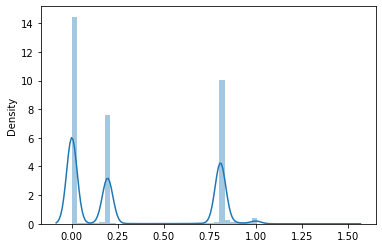

In [89]:
sns.distplot(test_mae_loss, bins=50,kde=True)

In [90]:
test_data_label

isDeviceWorking
DeviceId        time                                      
015262001278133 2021-06-15 01:10:39+10:00                1
                2021-06-15 01:11:37+10:00                1
                2021-06-15 01:12:40+10:00                1
                2021-06-15 01:13:40+10:00                1
                2021-06-15 01:14:42+10:00                1
...                                                    ...
015262001281806 2021-11-09 09:42:02+11:00                0
                2021-11-10 09:42:09+11:00                0
                2021-11-10 09:45:07+11:00                0
                2021-11-11 09:45:49+11:00                0
                2021-11-11 09:46:42+11:00                0

[336817 rows x 1 columns]

In [91]:
len(y_test_new)

336782

In [97]:
# Perform thresholding
THRESHOLD = 0.75

test_score_df = pd.DataFrame(index=pd.MultiIndex.from_tuples(test_index_list, names=('DeviceId', 'time')))
# test_score_df = pd.DataFrame(index=test_data_label[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['isDeviceWorking'] = test_data_label.isDeviceWorking
test_score_df['isDeviceWorking'] = y_test_new

In [98]:
# test_score_df.loc[test_score_df['anomaly'] == False]
test_score_df

loss  threshold  anomaly  \
DeviceId        time                                                      
015262001278323 2021-04-21 05:37:07+10:00  0.000004       0.75    False   
                2021-04-21 09:37:12+10:00  0.000004       0.75    False   
                2021-04-21 13:37:13+10:00  0.000004       0.75    False   
                2021-04-21 17:37:22+10:00  0.000004       0.75    False   
                2021-04-21 21:37:12+10:00  0.000004       0.75    False   
...                                             ...        ...      ...   
015262001278372 2021-07-05 18:59:01+10:00  0.193831       0.75    False   
                2021-07-05 19:03:59+10:00  0.193605       0.75    False   
                2021-07-05 19:08:58+10:00  0.193477       0.75    False   
                2021-07-05 19:13:57+10:00  0.193525       0.75    False   
                2021-07-05 19:19:09+10:00  0.193731       0.75    False   

                                           isDeviceWorking  
DeviceId        time                                        
015262001278323 2021-04-21 05:37:07+10:00                1  
                2021-04-21 09:37:12+10:00                1  
                2021-04-21 13:37:13+10:00                1  
                2021-04-21 17:37:22+10:00                1  
                2021-04-21 21:37:12+10:00                1  
...                                                    ...  
015262001278372 2021-07-05 18:59:01+10:00                0  
                2021-07-05 19:03:59+10:00                0  
                2021-07-05 19:08:58+10:00                0  
                2021-07-05 19:13:57+10:00                0  
                2021-07-05 19:19:09+10:00                0  

[336782 rows x 4 columns]

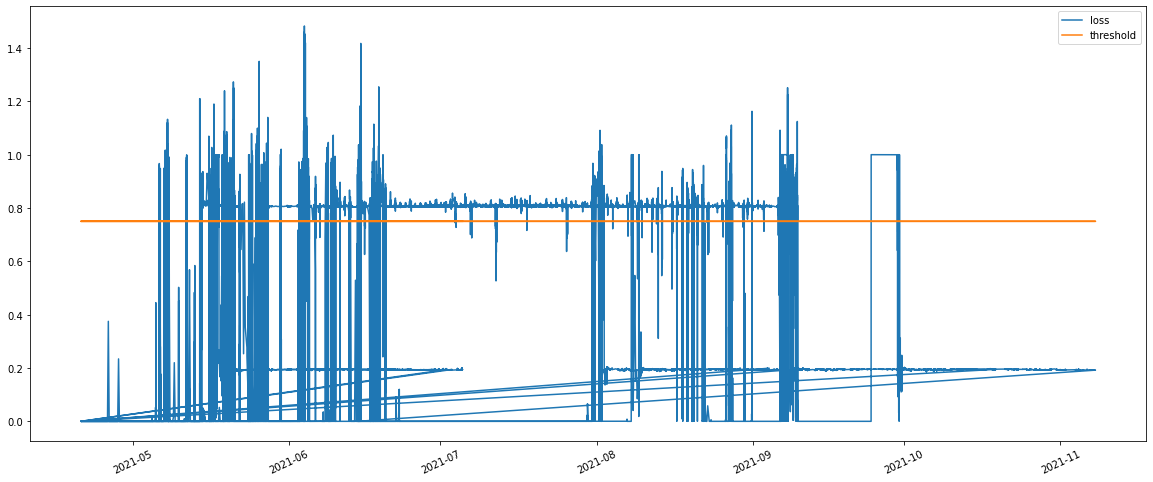

In [99]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(8)
plt.plot(test_score_df.index.get_level_values('time').values, test_score_df.loss, label = 'loss')
plt.plot(test_score_df.index.get_level_values('time').values,test_score_df.threshold, label = 'threshold')
plt.xticks(rotation=25)
plt.legend()

{'015262001278323', '015262001278315', '015262001278422', '015262001281806', '015262001278133', '015262001278513', '015262001278372'}


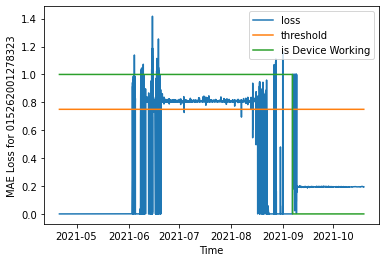

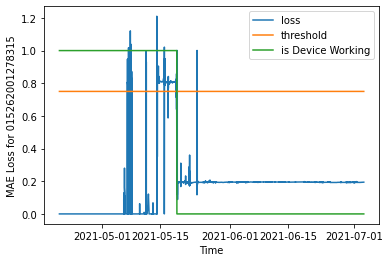

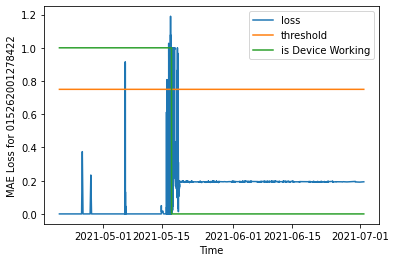

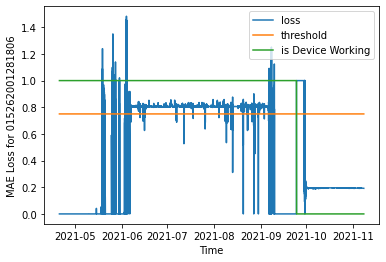

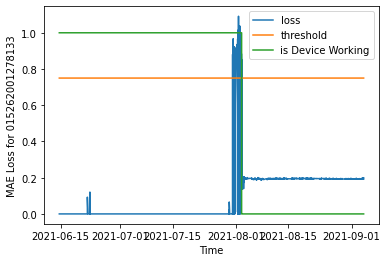

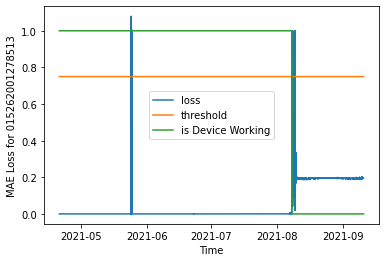

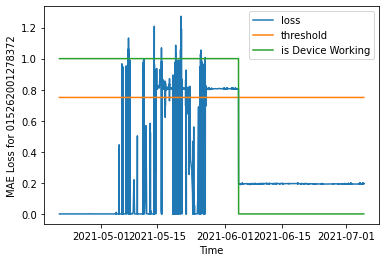

In [100]:
testdeviceIDs = set(test_score_df.index.get_level_values(0).tolist())
print(testdeviceIDs)
for device in testdeviceIDs:
    fig, ax = plt.subplots()
    test_preds = test_score_df[test_score_df.index.get_level_values('DeviceId') == device]
    loss = test_preds.loss
    threshold = test_preds.threshold
    trueValues = test_preds.isDeviceWorking

    ax.plot(test_preds.index.get_level_values('time').values, loss, label = 'loss')
    ax.plot(test_preds.index.get_level_values('time').values, threshold, label='threshold')
    ax.plot(test_preds.index.get_level_values('time').values, trueValues, label = 'is Device Working')

    # Set x-axis label
    ax.set_xlabel('Time')

    # Set y-axis label
    ax.set_ylabel('MAE Loss for '+device)

    # Set legend
    ax.legend()

    # Show plot
    plt.show()

In [101]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

loss  threshold  anomaly  \
DeviceId        time                                                      
015262001278323 2021-06-03 18:12:18+10:00  0.843337       0.75     True   
                2021-06-03 18:13:18+10:00  0.936017       0.75     True   
                2021-06-03 18:14:18+10:00  0.825020       0.75     True   
                2021-06-03 18:16:10+10:00  0.892466       0.75     True   
                2021-06-03 18:16:45+10:00  0.941899       0.75     True   
...                                             ...        ...      ...   
015262001278372 2021-06-04 15:38:45+10:00  0.804626       0.75     True   
                2021-06-04 15:39:47+10:00  0.804547       0.75     True   
                2021-06-04 15:40:57+10:00  0.804547       0.75     True   
                2021-06-04 15:42:03+10:00  0.804713       0.75     True   
                2021-06-04 15:43:16+10:00  0.804509       0.75     True   

                                           isDeviceWorking  
DeviceId        time                                        
015262001278323 2021-06-03 18:12:18+10:00                1  
                2021-06-03 18:13:18+10:00                1  
                2021-06-03 18:14:18+10:00                1  
                2021-06-03 18:16:10+10:00                1  
                2021-06-03 18:16:45+10:00                1  
...                                                    ...  
015262001278372 2021-06-04 15:38:45+10:00                1  
                2021-06-04 15:39:47+10:00                1  
                2021-06-04 15:40:57+10:00                1  
                2021-06-04 15:42:03+10:00                1  
                2021-06-04 15:43:16+10:00                1  

[111466 rows x 4 columns]

In [102]:
len(test_score_df)

336782